# CSGY 6923 Machine Learning - Fine tuning BERT for Question Answering

Install necessary dependencies

In [1]:
!pip install datasets torch transformers[torch] matplotlib seaborn wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 124.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 124.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 132.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 110.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 210.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 125.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 97.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 126.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 119.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 99.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 102.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Import necessary modules.

We use the `datasets` and `transformers` HuggingFace libraries

In [19]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer, DefaultDataCollator
import torch
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from datetime import datetime
from transformers.integrations import WandbCallback
from collections import Counter
import time

## Dataset.

The `SQuAD` dataset (Standard Question and Answering Dataset) is the dataset of choice for this fune tuning task

In [3]:
squad = load_dataset("squad", split="train[:5000]")
squad = squad.train_test_split(test_size=0.2)



enerating validation split: 100%|██████████| 10570/10570 [00:00<00:00, 697631.64 examples/s]

Coverting the dataset into a dictionary

In [4]:
data_dict = squad["train"].to_dict()

df = pd.DataFrame.from_dict(data_dict)

In [5]:
df.head()

,id,title,context,question,answers
0,56d12bda17492d1400aabb44,The_Legend_of_Zelda:_Twilight_Princess,"Ganondorf then revives, and Midna teleports Li...",Who does Midna teleport?,"{'text': ['Link and Zelda'], 'answer_start': [..."
1,56bf725c3aeaaa14008c9646,Beyoncé,"A self-described ""modern-day feminist"", Beyonc...",In which years did Time rate Beyonce in the 10...,"{'text': ['2013 and 2014'], 'answer_start': [9..."
2,56cda50b62d2951400fa67af,The_Legend_of_Zelda:_Twilight_Princess,"A high-definition remaster of the game, The Le...",On what date is Twilight Princess HD scheduled...,"{'text': ['March 5, 2016'], 'answer_start': [3..."
3,56be97c73aeaaa14008c912b,Beyoncé,Beyoncé announced a hiatus from her music care...,Which year did Beyonce and her father part bus...,"{'text': ['2010'], 'answer_start': [60]}"
4,56cfb9bf234ae51400d9bf07,Solar_energy,The total solar energy absorbed by Earth's atm...,What is the amount of solar energy absorbed by...,"{'text': ['approximately 3,850,000 exajoules (..."


We see that the dataset has multiple columns that determine the context and the position of the answer within the question

In [6]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

questions = [q.strip() for q in df["question"]]
context = [q.strip() for q in df["context"]]
inputs = tokenizer(
        questions,
        context,
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

In [7]:
offset_mapping = inputs.pop("offset_mapping")

start_positions = []
end_positions = []
answers = df['answers']
for i, offset in enumerate(offset_mapping):
    answer = answers[i]
    start_char = answer["answer_start"][0]
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    # If the answer is not fully inside the context, label it (0, 0)
    if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
        start_positions.append(0)
        end_positions.append(0)
    else:
        # Otherwise it's the start and end token positions
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

df["start_positions"] = start_positions
df["end_positions"] = end_positions

data = {'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'start_positions':start_positions,
        'end_positions': end_positions,
       }

Creating a Dataset from the augmented dataframe

In [8]:
df = pd.DataFrame(data)
df.to_csv('encoding_train.csv',index=False)
train = Dataset.from_pandas(df)

Doing the same preprocessing on the test dataset.

In [9]:
data_dict = squad["test"].to_dict()
# Create a DataFrame from the dictionary
df = pd.DataFrame.from_dict(data_dict)

questions = [q.strip() for q in df["question"]]
context = [q.strip() for q in df["context"]]
inputs = tokenizer(
        questions,
        context,
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

offset_mapping = inputs.pop("offset_mapping")

start_positions = []
end_positions = []
answers = df['answers']
for i, offset in enumerate(offset_mapping):
    answer = answers[i]
    start_char = answer["answer_start"][0]
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    # If the answer is not fully inside the context, label it (0, 0)
    if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
        start_positions.append(0)
        end_positions.append(0)
    else:
        # Otherwise it's the start and end token positions
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

df["start_positions"] = start_positions
df["end_positions"] = end_positions

data = {'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'start_positions':start_positions,
        'end_positions': end_positions,
       }
df = pd.DataFrame(data)
df.to_csv('encoding_test.csv',index=False)
test = Dataset.from_pandas(df)

## Visualizing the data

In [10]:
def analyze_squad_dataset(squad_data):
    question_types = [q.split()[0].lower() for q in squad_data['question']]
    answer_lengths = [len(ans['text'][0].split()) for ans in squad_data['answers']]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    question_counts = Counter(question_types).most_common(8)
    question_df = pd.DataFrame(question_counts, columns=['Type', 'Count'])
    
    sns.barplot(data=question_df, x='Count', y='Type', ax=ax1, 
                palette='viridis', alpha=0.8)
    ax1.set_title('Distribution of Question Types\nin SQuAD Dataset', 
                  fontsize=12, pad=15)
    ax1.set_xlabel('Number of Questions')
    
    sns.histplot(answer_lengths, bins=30, ax=ax2, 
                 color='darkblue', alpha=0.6)
    ax2.set_title('Distribution of Answer Lengths\nin Words', 
                  fontsize=12, pad=15)
    ax2.set_xlabel('Number of Words in Answer')
    ax2.set_ylabel('Count')
    
    plt.suptitle('SQuAD Dataset Characteristics', 
                fontsize=14, y=1.05)
    plt.tight_layout()
    
    stats_text = (f"Dataset Size: {len(squad_data)} questions\n"
                 f"Average Answer Length: {np.mean(answer_lengths):.1f} words\n"
                 f"Median Answer Length: {np.median(answer_lengths):.1f} words")
    
    fig.text(0.02, -0.1, stats_text, fontsize=10)
    
    return fig

/tmp/ipykernel_2858/2978020060.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=question_df, x='Count', y='Type', ax=ax1,


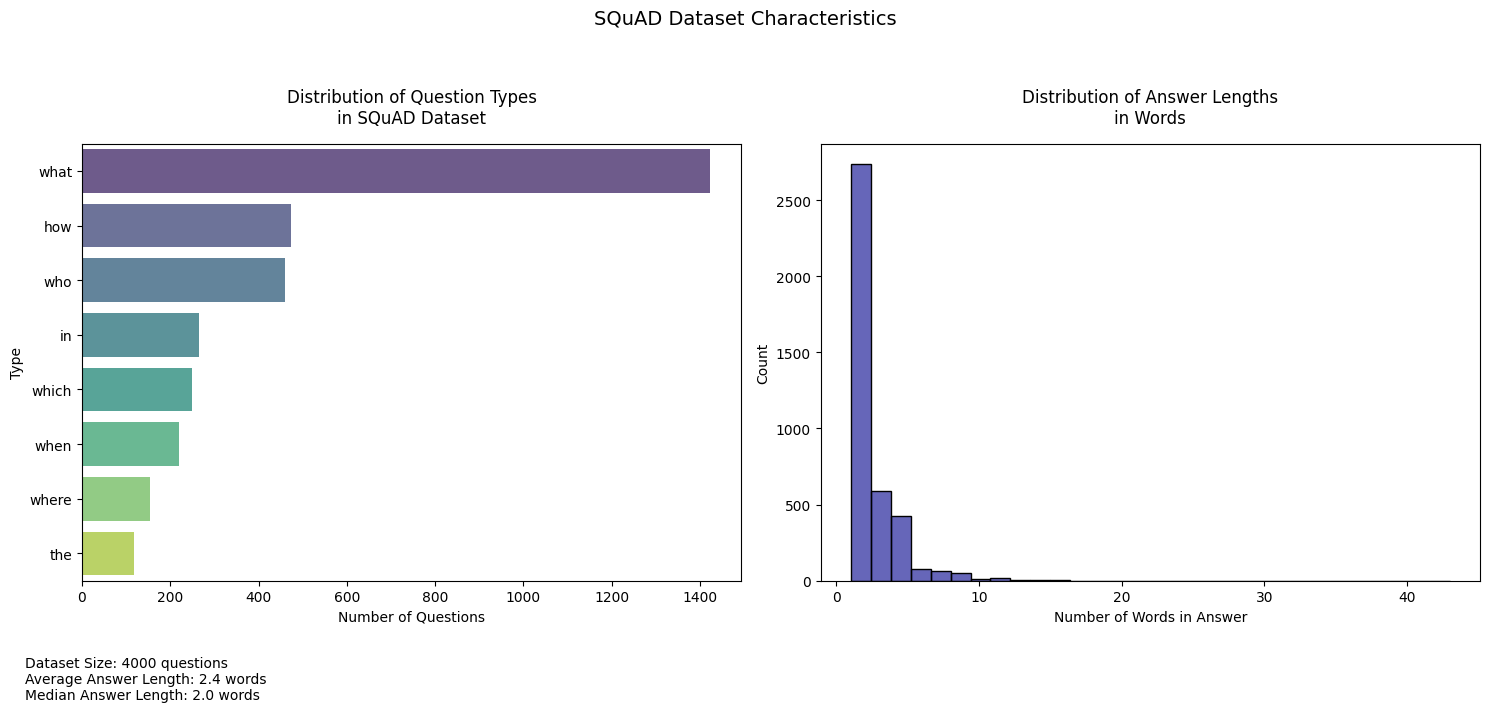

<Figure size 640x480 with 0 Axes>

In [11]:
fig = analyze_squad_dataset(squad["train"])
plt.show()
plt.savefig("squad.png")

## Initializing Weights and Biases (Wandb)

In [12]:
wandb.init(
    project="bert-question-answering",
    name="bert-squad-finetuning",
    config={
        "learning_rate": 2e-5,
        "train_batch_size": 16,
        "eval_batch_size": 16,
        "epochs": 3,
        "weight_decay": 0.01,
        "model_name": "distilbert-base-uncased",
        "max_length": 384,
        "dataset": "squad",
        "train_size": len(train),
        "eval_size": len(test)
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Training the model

In [13]:
data_collator = DefaultDataCollator()
model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased")

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
training_args = TrainingArguments(
    output_dir="./bert-qna",
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=100,
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
    report_to="wandb",
    logging_dir="./logs",
    logging_steps=100,
    logging_first_step=True,
)

/usr/local/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

/tmp/ipykernel_2858/1206778530.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [16]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss
100,4.260100,3.508577
200,3.166000,2.657261
300,2.307600,2.082113
400,1.858800,1.846466
500,1.619300,1.746188
600,1.400900,1.724698
700,1.354400,1.666783


TrainOutput(global_step=750, training_loss=2.2184805819193523, metrics={'train_runtime': 110.6063, 'train_samples_per_second': 108.493, 'train_steps_per_second': 6.781, 'total_flos': 1175877900288000.0, 'train_loss': 2.2184805819193523, 'epoch': 3.0})

## Evaluating the model

In [20]:
def evaluate_bert_qa(model, eval_dataset, tokenizer, batch_size=16):
    print("Evaluating BERT QA model performance...")
    
    eval_args = TrainingArguments(
        output_dir="./bert-qa-eval",
        do_train=False,
        do_eval=True,
        per_device_eval_batch_size=batch_size,
        report_to="wandb",
        metric_for_best_model="eval_loss",
        evaluation_strategy="steps",
        save_strategy="steps",
        eval_steps=100,
        save_steps=100,
        load_best_model_at_end=True,
        save_total_limit=2,
        logging_steps=100
    )
    
    evaluator = Trainer(
        model=model,
        args=eval_args,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        data_collator=DefaultDataCollator()
    )
    
    start_time = time.time()
    metrics = evaluator.evaluate()
    eval_time = time.time() - start_time
    
    perplexity = np.exp(metrics['eval_loss'])
    
    predictions = evaluator.predict(eval_dataset)
    exact_match = calculate_exact_match(predictions, eval_dataset)
    f1_score = calculate_f1_score(predictions, eval_dataset)
    
    start_perplexity = calculate_position_perplexity(predictions.predictions[0])
    end_perplexity = calculate_position_perplexity(predictions.predictions[1])
    avg_position_perplexity = (start_perplexity + end_perplexity) / 2
    
    wandb.log({
        "eval_loss": metrics["eval_loss"],
        "perplexity": perplexity,
        "start_position_perplexity": start_perplexity,
        "end_position_perplexity": end_perplexity,
        "average_position_perplexity": avg_position_perplexity,
        "exact_match_score": exact_match,
        "f1_score": f1_score,
        "eval_time_seconds": eval_time,
        "eval_samples_per_second": len(eval_dataset) / eval_time
    })
    
    print("\nEvaluation Results:")
    print(f"Evaluation Loss: {metrics['eval_loss']:.4f}")
    print(f"Perplexity: {perplexity:.2f}")
    print(f"Position Perplexity (Start/End): {start_perplexity:.2f}/{end_perplexity:.2f}")
    print(f"Exact Match Score: {exact_match:.2%}")
    print(f"F1 Score: {f1_score:.2%}")
    print(f"Evaluation Time: {eval_time:.2f} seconds")
    print(f"Processing Speed: {len(eval_dataset) / eval_time:.2f} samples/second")
    
    return metrics["eval_loss"], exact_match, f1_score, perplexity, eval_time

def calculate_position_perplexity(logits):
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)
    
    eps = 1e-10
    log_probs = -torch.log(probs + eps)
    
    # Calculate perplexity as exp(average cross-entropy)
    avg_cross_entropy = log_probs.mean().item()
    return np.exp(avg_cross_entropy)

def calculate_exact_match(predictions, dataset):
    correct = 0
    total = len(predictions.predictions[0])
    
    for i in range(total):
        start_logits = predictions.predictions[0][i]
        end_logits = predictions.predictions[1][i]
        
        start_pred = np.argmax(start_logits)
        end_pred = np.argmax(end_logits)
        
        # Compare with ground truth
        if start_pred == dataset[i]['start_positions'] and end_pred == dataset[i]['end_positions']:
            correct += 1
    
    return correct / total

def calculate_f1_score(predictions, dataset):
    f1_scores = []
    
    for i in range(len(predictions.predictions[0])):
        start_logits = predictions.predictions[0][i]
        end_logits = predictions.predictions[1][i]
        
        start_pred = np.argmax(start_logits)
        end_pred = np.argmax(end_logits)
        
        pred_span = set(range(start_pred, end_pred + 1))
        true_span = set(range(dataset[i]['start_positions'], dataset[i]['end_positions'] + 1))
        
        overlap = len(pred_span.intersection(true_span))
        precision = overlap / len(pred_span) if len(pred_span) > 0 else 0
        recall = overlap / len(true_span) if len(true_span) > 0 else 0
        
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
    
    return np.mean(f1_scores)

In [21]:
print("Starting BERT QA evaluation...")
eval_loss, exact_match, f1_score, perplexity, eval_time = evaluate_bert_qa(model, test, tokenizer)
print("\nFinal Results:")
print(f"Evaluation Loss: {eval_loss:.4f}")
print(f"Perplexity: {perplexity:.2f}")
print(f"Exact Match Score: {exact_match:.2%}")
print(f"F1 Score: {f1_score:.2%}")
print(f"Total Evaluation Time: {eval_time:.2f} seconds")

/usr/local/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2858/669481014.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  evaluator = Trainer(
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting BERT QA evaluation...
Evaluating BERT QA model performance...



Evaluation Results:
Evaluation Loss: 1.6668
Perplexity: 5.30
Position Perplexity (Start/End): 32915.69/31366.08
Exact Match Score: 42.40%
F1 Score: 54.03%
Evaluation Time: 2.53 seconds
Processing Speed: 394.54 samples/second

Final Results:
Evaluation Loss: 1.6668
Perplexity: 5.30
Exact Match Score: 42.40%
F1 Score: 54.03%
Total Evaluation Time: 2.53 seconds


## Model Inference - Question Answering

Load the model into memory

In [22]:
MODEL_PATH = "./bert-qna/checkpoint-750"
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Setting the model to evaluation mode

In [23]:
model.eval()

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
     

Create a `BertQuestionAnswering` helper class to visualize inference

In [24]:
class BERTQuestionAnswering:
    def __init__(self, model_path):
        self.tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
        self.model = AutoModelForQuestionAnswering.from_pretrained(model_path)
        self.model.eval()
        
    def answer_question(self, question, context, display_attention=False):
        # Tokenize input
        inputs = self.tokenizer(
            question,
            context,
            add_special_tokens=True,
            return_tensors="pt",
            max_length=384,
            truncation="only_second",
            padding="max_length"
        )
        
        # Get model predictions
        with torch.no_grad():
            outputs = self.model(**inputs)
            
        # Get start and end positions
        start_scores = outputs.start_logits.softmax(dim=-1)
        end_scores = outputs.end_logits.softmax(dim=-1)
        
        # Find the most likely answer span
        start_idx = torch.argmax(start_scores)
        end_idx = torch.argmax(end_scores)
        
        # Convert tokens to answer text
        answer_tokens = inputs.input_ids[0][start_idx:end_idx + 1]
        answer_text = self.tokenizer.decode(answer_tokens)
        
        # Calculate confidence score
        confidence = float(start_scores[0][start_idx] * end_scores[0][end_idx])
        
        return {
            "answer": answer_text,
            "confidence": confidence,
            "start_idx": start_idx.item(),
            "end_idx": end_idx.item(),
            "token_scores": {
                "start": start_scores[0].tolist(),
                "end": end_scores[0].tolist()
            }
        }
    
    def visualize_answer(self, question, context, result, save_html=False, filename=None):
        # Create HTML for highlighted answer
        context_words = context.split()
        answer_words = result["answer"].split()
        
        highlighted_context = []
        for i, word in enumerate(context_words):
            if any(answer_word in word for answer_word in answer_words):
                highlighted_context.append(f'<span style="background-color: #FFE599; font-weight: bold;">{word}</span>')
            else:
                highlighted_context.append(word)
        
        html = f"""
        <div style="font-family: Arial; padding: 20px; border: 1px solid #ddd; border-radius: 5px; margin: 10px 0;">
            <div style="font-size: 18px; color: #2F5496; margin-bottom: 10px;">
                <strong>Question:</strong> {question}
            </div>
            <div style="font-size: 16px; margin-bottom: 15px;">
                <strong>Context:</strong> {' '.join(highlighted_context)}
            </div>
            <div style="font-size: 18px; color: #2F5496;">
                <strong>Answer:</strong> {result["answer"]} 
                <span style="color: #666; font-size: 14px;">(Confidence: {result["confidence"]:.2%})</span>
            </div>
        </div>
        """
        
        display(HTML(html))
        if save_html:
            if filename is None:
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                filename = f'qa_result_{timestamp}.html'
            
            with open(filename, 'w', encoding='utf-8') as f:
                f.write(html)
            print(f"HTML visualization saved to {filename}")
    
    def plot_token_scores(self, question, context, result, save_path=None):
        # Tokenize the input to get token mappings
        tokens = self.tokenizer.tokenize(question + " " + context)
        
        # Create score visualization
        plt.figure(figsize=(15, 5))
        
        # Plot start scores
        plt.subplot(1, 2, 1)
        sns.barplot(x=range(len(tokens[:20])), y=result["token_scores"]["start"][:20])
        plt.title("Start Position Scores")
        plt.xticks(range(len(tokens[:20])), tokens[:20], rotation=45, ha='right')
        
        # Plot end scores
        plt.subplot(1, 2, 2)
        sns.barplot(x=range(len(tokens[:20])), y=result["token_scores"]["end"][:20])
        plt.title("End Position Scores")
        plt.xticks(range(len(tokens[:20])), tokens[:20], rotation=45, ha='right')
        
        plt.tight_layout()
        
        # Save the plot if a path is provided
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
            print(f"Plot saved to {save_path}")
        
        plt.show()

Helper function to asnwer questions

In [25]:
def log_qa_predictions(qa_system, examples):
    prediction_table = wandb.Table(columns=["Question", "Context", "Predicted Answer", "Confidence"])
    
    for question, context in examples:
        result = qa_system.answer_question(question, context)
        prediction_table.add_data(
            question,
            context,
            result["answer"],
            f"{result['confidence']:.2%}"
        )
    
    wandb.log({"predictions": prediction_table})

In [26]:
def answer_questions():
    # Initialize the QA system
    qa_system = BERTQuestionAnswering(model_path=MODEL_PATH)
    
    # Example 1: Historical fact
    context1 = """The Apollo 11 spacecraft landed on the Moon on July 20, 1969. 
                  Neil Armstrong became the first human to step onto the lunar surface, 
                  followed by Buzz Aldrin. They spent about two and a half hours exploring 
                  and collecting samples."""
    question1 = "Who was the first person to walk on the Moon?"
    
    # Example 2: Scientific explanation
    context2 = """Photosynthesis is the process by which plants convert light energy 
                  into chemical energy. This process occurs in the chloroplasts, 
                  specifically using chlorophyll pigments. The end products are 
                  glucose and oxygen, while carbon dioxide and water are the raw materials."""
    question2 = "What are the end products of photosynthesis?"
    
    # Example 3: Complex reasoning
    context3 = """The Industrial Revolution began in Britain in the late 18th century. 
                  It brought about major changes in agriculture, manufacturing, mining, 
                  and transport. While it led to economic growth and technological progress, 
                  it also caused environmental pollution and poor working conditions for many laborers."""
    question3 = "What were the negative effects of the Industrial Revolution?"
    
    # Process each example
    examples = [
        (question1, context1),
        (question2, context2),
        (question3, context3)
    ]
    for question, context in examples:
        print("\n" + "="*80 + "\n")
        result = qa_system.answer_question(question, context)
        qa_system.visualize_answer(question, context, result, save_html=True)
        qa_system.plot_token_scores(question, context, result, save_path="./plots.png")

HTML visualization saved to qa_result_20241212_182144.html
Plot saved to ./plots.png


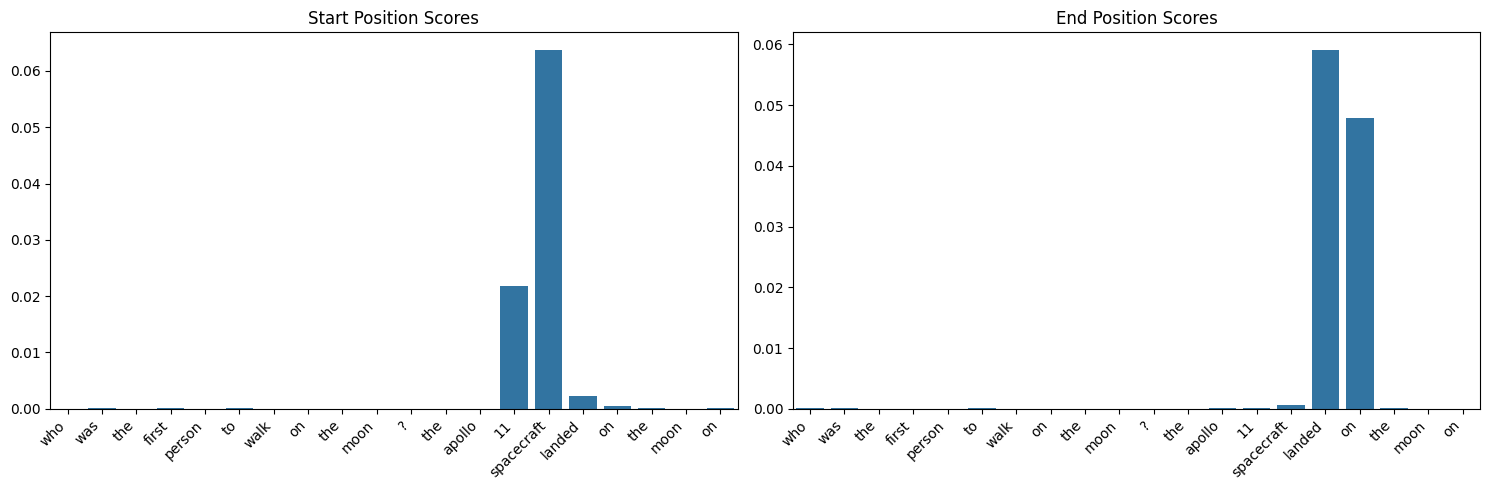

HTML visualization saved to qa_result_20241212_182145.html
Plot saved to ./plots.png


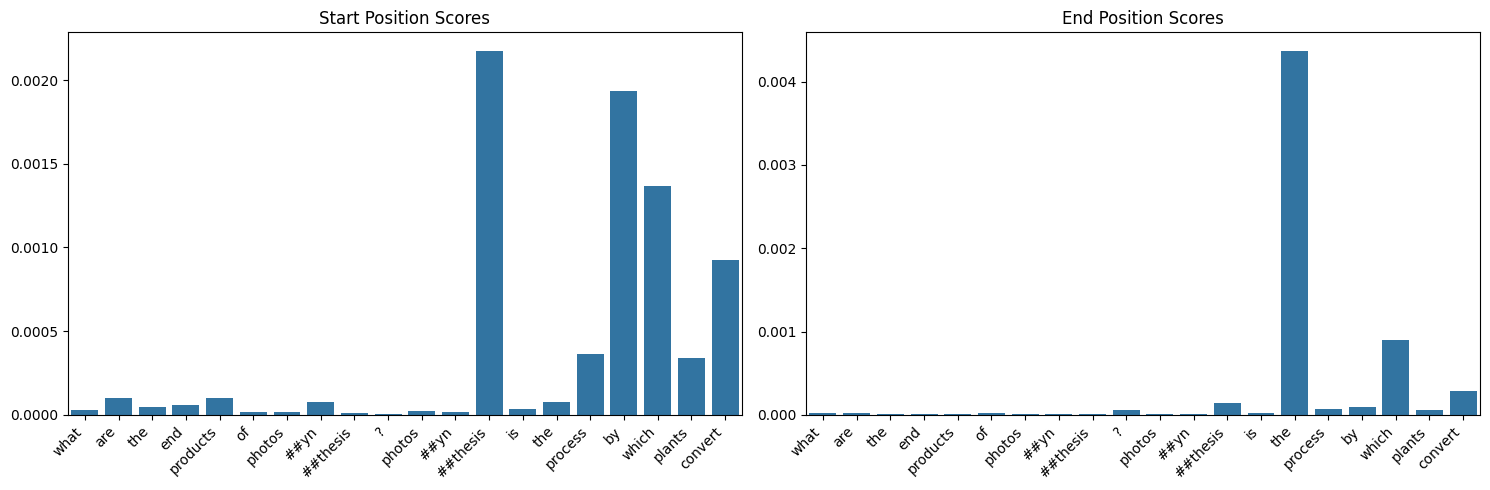

HTML visualization saved to qa_result_20241212_182146.html
Plot saved to ./plots.png


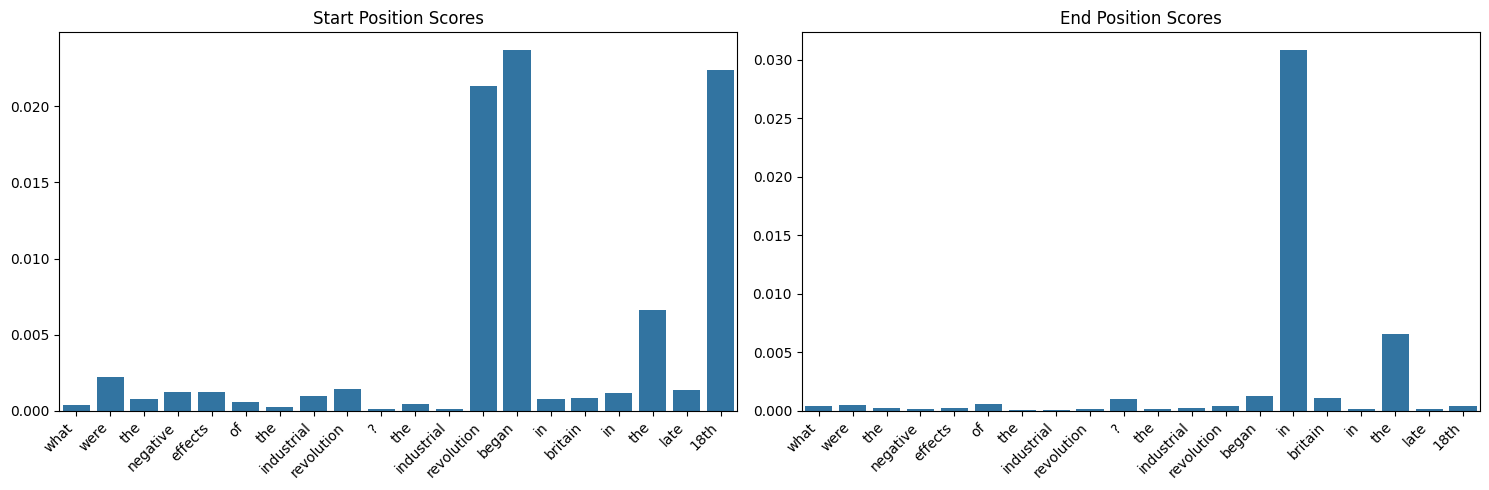

In [27]:
answer_questions()

In [28]:
corpus = """
The Edo period in Japan, spanning from 1603 to 1867, witnessed a profound evolution in literary expression, particularly in works exploring themes of melancholy, impermanence, and existential contemplation. During this time of enforced peace and isolation under Tokugawa rule, Japanese writers developed unique approaches to expressing psychological depth and emotional suffering, often interweaving Buddhist concepts of mono no aware (the pathos of things) with deeply personal narratives.
Ueda Akinari, writing in the mid-18th century, emerged as a master of the supernatural tale infused with melancholic undertones. His masterpiece "Ugetsu Monogatari" (Tales of Moonlight and Rain), published in 1776, presented ghost stories that weren't merely frightening, but deeply sorrowful. In "The Reed-Choked House," perhaps the collection's most poignant tale, a merchant returns home after a long absence to find his wife still waiting, only to discover she had died years ago, sustained purely by her devotion. The story exemplifies the period's preoccupation with the transient nature of human relationships and the lingering pain of loss.
The poet Yosa Buson, though primarily known for his haiku, contributed significantly to the period's melancholic literary tradition. Writing in the shadow of Matsuo Bashō, Buson captured moments of exquisite sadness in his verses. His poem about autumn evening, where he describes a lone crow settling on a bare branch, became emblematic of the era's ability to find beauty in desolation. Buson's works often portrayed the changing seasons as metaphors for human impermanence, a theme that resonated deeply with Edo period readers living in an increasingly urbanized society.
Women writers of the period, despite facing significant social restrictions, produced some of the era's most psychologically nuanced works. Tadano Makuzu's "Solitary Thoughts" (Hitori Kangae), written in the early 1800s, offered a piercing examination of female melancholy in Edo society. Her essays, though not widely circulated during her lifetime, revealed the profound isolation experienced by educated women in a rigidly hierarchical society. Makuzu's writings often returned to themes of intellectual loneliness and the bitterness of unfulfilled potential.
The development of share-bon (books of wit and fashion) in the late Edo period provided another avenue for exploring melancholic themes, particularly through the lens of urban life. These works, while ostensibly focusing on the pleasure quarters, frequently revealed the emptiness beneath the surface of social interactions. The anonymous "A Fraudulent Biography" (1813) presented a devastating portrait of a man seeking meaning in the artificial world of the pleasure districts, only to find deeper despair.
Particularly significant was the emergence of watakushi shosetsu (I-novel) precursors during the late Edo period. These confessional narratives, while not yet fully developed into the form they would take in the Meiji era, began exploring themes of personal alienation and emotional authenticity. Writers like Takizawa Bakin, though famous for his epic tales, occasionally produced deeply personal works that questioned the relationship between artistic expression and inner turmoil.
The influence of Chinese literature, particularly works from the Ming dynasty, contributed to the development of melancholic themes in Edo writing. Japanese authors found in Chinese romantic tragedies a model for expressing profound sadness while maintaining aesthetic refinement. This influence is particularly visible in the works of Tsuga Teishō, whose "New Tales for the Trimmed Lampwick" (1745) adapted Chinese ghost stories into Japanese contexts, emphasizing the sorrowful rather than the frightening aspects of supernatural encounters.
The cultural practice of michiyuki (journey scenes) in literature took on new psychological depth during the Edo period. These travel narratives, traditionally used in drama, became vehicles for exploring emotional journeys through physical landscapes. Writers began using the michiyuki framework to depict internal struggles, with physical landmarks serving as metaphors for psychological states. The anonymous "Journey of Sorrows" (1789) exemplified this tradition, following a protagonist whose physical journey through Japan mirrors his descent into melancholy.
As the Edo period drew to a close, a new form of melancholic expression emerged in the form of ninjōbon (books of human feeling). These works, while often centered on love stories, delved deep into the psychology of suffering. Tamenaga Shunsui's works, though popular in nature, captured the growing sense of social displacement and emotional complexity that characterized the late Edo period. His characters often struggled with the conflict between social obligations (giri) and personal feelings (ninjō), a tension that produced some of the era's most moving literary expressions of melancholy.
The influence of Buddhist thought remained strong throughout the period, particularly the concept of mujō (impermanence). Writers incorporated this philosophical framework into their explorations of melancholy, suggesting that the recognition of life's transient nature was itself a source of both beauty and sorrow. This sophisticated approach to emotional suffering distinguished Edo period literature from mere expressions of sadness, elevating it to a form of spiritual and aesthetic contemplation.
"""

In [29]:
question  = "what literary themes were prominnet in Edo period Japan?"

In [30]:
qa = BERTQuestionAnswering(MODEL_PATH)
results = qa.answer_question(question, corpus)
qa.visualize_answer(question, corpus, results, save_html=True)

HTML visualization saved to qa_result_20241212_182151.html


In [31]:
wandb.finish()

average_position_perplexity,▁
end_position_perplexity,▁
eval/loss,█▅▃▂▁▁▁▁
eval/model_preparation_time,▁
eval/runtime,▁▂▂▂▂▄▃█
eval/samples_per_second,█▇▇▇▇▅▆▁
eval/steps_per_second,█▇▇▇▇▅▆▁
eval_loss,▁
eval_samples_per_second,▁
eval_time_seconds,▁
exact_match_score,▁
